In [25]:
import pandas as pd
import numpy as np
import warnings
# Reproducibility
import random
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Stats to get trend
from statsmodels.tsa.seasonal import seasonal_decompose

# scikit-learn 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
# Tensorflow (for LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)


In [26]:
path = r"C:/Users/TurnerJosh/Desktop/SensitiveData/GoodSalesData1.xlsx"
df = pd.read_excel(path)

In [27]:
df.columns

Index(['Charge Type', 'Order Type', 'Sales Invoice Count', 'Charge Amount',
       'COGS Amount', 'Cost Adjustment Amount', 'Cost Amount',
       'Discount Amount', 'Invoice Amount', 'Invoice Date'],
      dtype='object')

In [28]:
df = df[['Charge Amount','Invoice Date']].loc[df['Charge Amount'] != 0]
# Rename date series 'ds' and time series 'ts'
DF = df.rename(columns = {'Invoice Date': 'ds', 'Charge Amount': 'ts'})

In [29]:
DF.isna().sum()

ts    0
ds    0
dtype: int64

In [30]:
# Dealing with Outliers
new_df = DF["ts"][(DF['ts'] < DF['ts'].mean() + 3*DF['ts'].std()) & (DF['ts'] > DF['ts'].mean() - 3*DF['ts'].std())]


In [68]:
# Copy dataframe add log if necessary
DF['log_Sum_Unit_Price'] = np.log(DF['ts'])
DF = DF.copy()

c:\Users\TurnerJosh\Desktop\TestProj\Test\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
# Prepare time series for LSTM 
DF.sort_values('ds',inplace=True)
# Decom_Df.sort_index()

In [70]:
# Normalize the data
# scaler = MinMaxScaler(feature_range=(0, 1))
# DF['ts'] = scaler.fit_transform(DF[['ts']])

In [10]:
# Create sequences of fixed length (e.g., 30 time steps)
sequence_length = 90

X, y = [], []
for i in range(len(DF) - sequence_length):
    X.append(DF['ts'].iloc[i:i + sequence_length])
    y.append(DF['ts'].iloc[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
y.shape

(4528,)

In [ ]:
# # Create sequences of fixed length (e.g., 30 time steps)
# sequence_length = 90

# X, y = [], []
# for i in range(len(DF) - sequence_length):
#     X.append(DF['ts'].iloc[i:i + sequence_length])
#     y.append(DF['ts'].iloc[i:i + sequence_length].mean())

# X = np.array(X)
# y = np.array(y)

# # Reshape input to be [samples, time steps, features]
# X = np.reshape(X, (X.shape[0], X.shape[1], 1))
# y.shape

In [11]:
actuals = DF['ts'].values

# actuals = scaler.inverse_transform(actuals.reshape(-1, 1))
y_test_actuals = actuals[sequence_length:]

y_test_actuals.shape,y.shape

((4528,), (4528,))

In [87]:
y_test_actuals

array([16783,   255, 10205, ...,  1935,   420,  1210], dtype=int64)

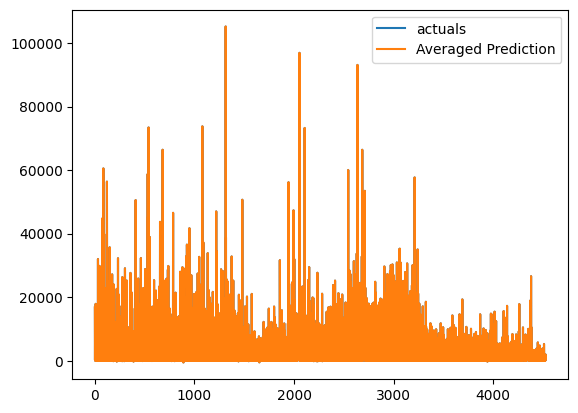

In [12]:
plt.plot(y_test_actuals,label = 'actuals')
plt.plot(y,label = 'Averaged Prediction')
plt.legend()
plt.show()

In [58]:
DF['ts'].iloc[sequence_length:].values.shape,y.shape

((4528,), (4528,))

In [90]:
# Evaluate Model
test_rmse = np.sqrt(mean_squared_error(y_test_actuals, y))
r2_score(y_test_actuals, y)
print(f"RMSE: {test_rmse}")

RMSE: 7532.181483235237


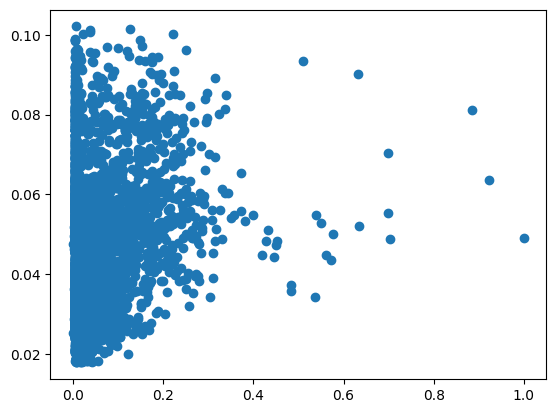

In [61]:
plt.scatter(y_test_actuals,y)
plt.show()

In [14]:
#Train/Test
X_train,y_train,X_test,y_test = X[:int(0.8*len(X))],y[:int(0.8*len(X))],X[int(0.8*len(X)):],y[int(0.8*len(X)):]

In [17]:
# Create LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(5, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [18]:
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
114/114 [==============================] - 11s 64ms/step - loss: 92442792.0000 - val_loss: 15838596.0000
Epoch 2/50
114/114 [==============================] - 6s 54ms/step - loss: 92352072.0000 - val_loss: 15806175.0000
Epoch 3/50
114/114 [==============================] - 6s 54ms/step - loss: 92291048.0000 - val_loss: 15777183.0000
Epoch 4/50
114/114 [==============================] - 6s 57ms/step - loss: 92234256.0000 - val_loss: 15748450.0000
Epoch 5/50
114/114 [==============================] - 7s 61ms/step - loss: 92176368.0000 - val_loss: 15720082.0000
Epoch 6/50
114/114 [==============================] - 7s 62ms/step - loss: 92120096.0000 - val_loss: 15692243.0000
Epoch 7/50
114/114 [==============================] - 7s 59ms/step - loss: 92065760.0000 - val_loss: 15665309.0000
Epoch 8/50
114/114 [==============================] - 7s 59ms/step - loss: 92011736.0000 - val_loss: 15638587.0000
Epoch 9/50
114/114 [==============================] - 7s 60ms/step - loss: 9195

29/29 [==============================] - 0s 16ms/step


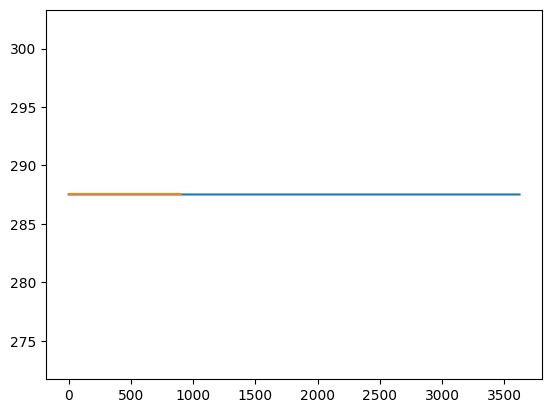

In [19]:
# make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
plt.plot(y_train_pred)
plt.plot(y_test_pred)
plt.show()

In [21]:
DF.ts

8111    0.052548
8113    0.005406
8114    0.052548
5208    0.005453
5129    0.005444
          ...   
7076    0.012693
8065    0.011889
1623    0.023580
8066    0.009262
2289    0.016728
Name: ts, Length: 4618, dtype: float64

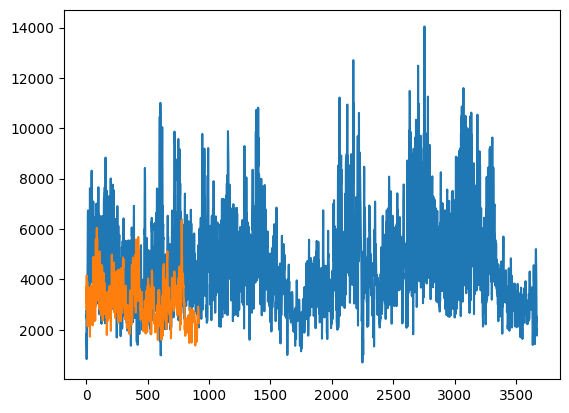

In [15]:
# Inverse transform the predictions to put in terms of sales (no log)
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)
plt.plot(y_train_pred)
plt.plot(y_test_pred)
plt.show()

In [16]:
# # Calculate the trend values corresponding to the train and test sets
actuals = DF['ts'].values
# trend_test = trend_values[int(0.8 * len(X)):].reshape(-1,1)
y_train_actuals = actuals[:int(0.8 * len(X))]
y_train_actuals = y_train_actuals.reshape(-1, 1)

y_test_actuals = actuals[sequence_length:]
y_test_actuals = y_test_actuals[int(0.8 * len(X)):]
y_test_actuals = y_test_actuals.reshape(-1, 1)

In [28]:
actuals = DF['ts'].values

actuals = scaler.inverse_transform(actuals.reshape(-1, 1))
y_train_actuals = actuals[:int(0.8 * len(X))]
y_train_actuals = y_train_actuals.reshape(-1, 1)

y_test_actuals = actuals[sequence_length:]
y_test_actuals = y_test_actuals[int(0.8 * len(X)):]
y_test_actuals = y_test_actuals.reshape(-1, 1)
# y_train_actual = scaler.inverse_transform(y_train_actuals.reshape(-1, 1))
# y_test_actual = scaler.inverse_transform(y_test_actuals.reshape(-1, 1))

In [24]:
# y_train_actuals.shape,
# y_test_actuals.shape
# y_train_pred.shape
y_test_pred.shape,y_test_actuals.shape

((906, 1), (4528,))

In [21]:
# Evaluate Model
# train_rmse = np.sqrt(mean_squared_error(y_train_actuals, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_actuals, y_test_pred))

# print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

ValueError: Found input variables with inconsistent numbers of samples: [4528, 906]

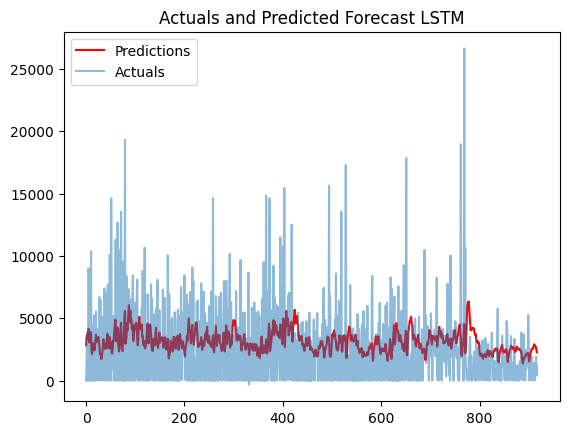

In [33]:
plt.plot(y_test_pred,c='red',label='Predictions')
plt.title('Actuals and Predicted Forecast LSTM')
plt.plot(y_test_actuals,label='Actuals',alpha=0.5)
plt.legend()
plt.show()